# CICY4: Training results + Inference [All models]

In this notebook, 12 trained models were loaded to calculate the train, validation and test accuracies of the 72% dataset. 
The models can be broadly categorized into CNN-RNN (either GRU or LSTM) hybrid architecture and LSTM-based architecture. 

- CNN-GRU hybrids :
    - CNN-GRU-384
    - CNN-GRU-416
    - ResNet-GRU-256
    - ResNet-GRU-400
- CNN-LSTM hybrids:  
    - CNN-LSTM-256
    - CNN-LSTM-384
    - CNN-LSTM-400
    - CNN-LSTM-416
- LSTM-based:
    - LSTM-400
    - LSTM-424
    - LSTM-448
    - LSTM-456
    
 The best performing model so far is CNN-LSTM-400, followed by LSTM-448 and LSTM-424. These 3 models were trained on the enlarged 80% dataset. The retrained models were also loaded to calculate the test accuracies on the 80% dataset.  
 

In [2]:
import numpy as np
import pandas as pd
import random
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# Load data

In [5]:
#72% dataset
X_train = np.load('/kaggle/input/calabi-yau-cicy-4-folds/conf_Xtrain.npy')
X_test = np.load('/kaggle/input/calabi-yau-cicy-4-folds/conf_Xtest.npy')

y_train = np.load('/kaggle/input/calabi-yau-cicy-4-folds/hodge_ytrain.npy')
y_test= np.load('/kaggle/input/calabi-yau-cicy-4-folds/hodge_ytest.npy')

#Convert data to torch tensor with float32 precision 
#(needed to be compatible with the floating decision of the network parameters)
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

X_test = torch.from_numpy(X_test.astype(np.float32)) 
y_test= torch.from_numpy(y_test.astype(np.float32))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([652092, 16, 20]) torch.Size([181137, 16, 20])
torch.Size([652092, 4]) torch.Size([181137, 4])


In [6]:
#80% dataset
X_train_80 = np.load('/kaggle/input/calabi-yau-cicy-4-folds/conf_Xtrain_80.npy')
X_test_80 = np.load('/kaggle/input/calabi-yau-cicy-4-folds/conf_Xtest_80.npy')

y_train_80 = np.load('/kaggle/input/calabi-yau-cicy-4-folds/hodge_ytrain_80.npy')
y_test_80= np.load('/kaggle/input/calabi-yau-cicy-4-folds/hodge_ytest_80.npy')

#Convert data to torch tensor with float32 precision 
#(needed to be compatible with the floating decision of the network parameters)
X_train_80 = torch.from_numpy(X_train_80.astype(np.float32))
y_train_80 = torch.from_numpy(y_train_80.astype(np.float32))

X_test_80 = torch.from_numpy(X_test_80.astype(np.float32)) 
y_test_80= torch.from_numpy(y_test_80.astype(np.float32))

print(X_train_80.shape, X_test_80.shape)
print(y_train_80.shape, y_test_80.shape)

torch.Size([724547, 16, 20]) torch.Size([108682, 16, 20])
torch.Size([724547, 4]) torch.Size([108682, 4])


In [7]:
class CICY4Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y        
    def __len__(self):
        return len(self.X)      
    def __getitem__(self, idx):
        X0 = self.X[idx]
        y0 = self.y[idx]  
        return X0, y0
        
train_set = CICY4Dataset(X_train, y_train)
test_set = CICY4Dataset(X_test, y_test)

train_set_80 = CICY4Dataset(X_train_80, y_train_80)
test_set_80 = CICY4Dataset(X_test_80, y_test_80)

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

train_loader_80 = DataLoader(train_set_80, batch_size=128, shuffle=True)
test_loader_80 = DataLoader(test_set_80, batch_size=128, shuffle=False)

# Utility functions

In [10]:
################## GET PREDICTIONS + ACCURACY #####################
def get_pred_n_acc(models, device, dataloader, num_iter):
    i = 0
    ypreds =[]
    targets = []
    #The last batch might not have size 128
    while i< num_iter:
        for data, target in dataloader:
            #this empty list is to hold all models' preds
            ypred = []    
            data= data.to(device)
            data = data.to(torch.float32)
            target = target.to(torch.float32)
            #append the 'i^th' target
            targets.append(target)
            for model in models:
                model.eval()
                yp = model(data)
                yp = yp.detach().cpu().numpy()
                ypred.append(yp)
            #take the mean of all models' predictions
            ypred = np.array(ypred).mean(axis = 0)
            ypred = np.round(ypred)
            i+=1
            #append ypred, targets inside the 'i' loop
            # append the 'i^th' mean prediction
            ypreds.append(ypred)   
            if i == num_iter:
                break 
     #Do not convert ypreds, targets to np.array at this point,
    #since the last batch has a different size, causing an error !
    #CALCULATING ACCURACY    
    yp =  np.concatenate([ypreds[j] for j in range(len(ypreds))], axis = 0)
    tgs =  np.concatenate([targets[j] for j in range(len(targets))], axis = 0)
    h11_acc = ((yp[:,0] == tgs[:,0]).sum())/len(yp)
    h21_acc = ((yp[:,1] == tgs[:,1]).sum())/len(yp)
    h31_acc = ((yp[:,2] == tgs[:,2]).sum())/len(yp)
    h22_acc = ((yp[:,3] == tgs[:,3]).sum())/len(yp)
    acc = [h11_acc*100,h21_acc*100,h31_acc*100,h22_acc*100 ]
    return  yp, tgs, acc

In [11]:
def load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader):
    trained_model = torch.load(load_model_weight)  
    yt, tgt, acct = get_pred_n_acc([trained_model], device, train_loader, num_iter = len(train_loader))
    #validation accuracy
    #yv, tgv, accv = get_pred_n_acc([trained_model], device, val_loader, num_iter = len(val_loader))
    print(f'\n Train accuracies for {model_name}: {acct} ')
    #print(f'\n Validation accuracies for {model_name}: {accv}')
    #Test accuracy
    yts, tgts, accts = get_pred_n_acc([trained_model], device, test_loader, num_iter = len(test_loader))
    print(f'\n Test accuracies for {model_name}: {accts} \n')
    return trained_model, acct, accts, yts

# Network building blocks

In [12]:
# CNN BLOCK
class CNN_block(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,128, 4, 1)
        #self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 3, 1)
        #self.bn2 = nn.BatchNorm2d(64)
        self.mxpool = nn.MaxPool2d(2,2)
        #self.conv3 = nn.Conv2d(128,64, 2, 1)
        self.flat = nn.Flatten()
        self.conv_total = nn.Sequential(
            self.conv1,
            self.mxpool,
            self.conv2,
            self.mxpool
        )
    def forward(self,x):
        x = F.relu(self.conv_total(x))
        #reshape is the same as flat(x)
        #x = x.reshape(x.shape[0], -1)
        x = self.flat(x)   
        return x

In [13]:
#RESNET BLOCK
# CNN ###############################
class ResNet_block(nn.Module):    
    def __init__(self, filters, kernels):
        super().__init__()
        f1, f2, f3 = filters
        k1, k2, k3 = kernels
        self.conv1 = nn.Conv2d(1,f1, k1, 1)
        self.conv2 = nn.Conv2d(f1,f2, k2, 1)
        self.conv3 = nn.Conv2d(f2,f3, k3, 1)
        self.maxpool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.relu = nn.ReLU()
        #this layer is to get the identity to have
        #the same shape as the other branch, bias = False
        self.fc0 = nn.Linear(320,256, bias = False)
        #convolution branch/main branch
        self.conv_total = nn.Sequential(
            self.conv1,
            self.maxpool,
            self.relu,
            self.conv2,
            self.maxpool,
            self.relu,
            self.conv3,
            self.flat
        )
        #shortcut branch
        self.shortcut = nn.Sequential(self.flat, self.fc0)

    def forward(self,x):
        #x_i and x must have the same shape
        x_i = self.shortcut(x)
        x = self.conv_total(x)
        xt = x+ x_i
        #xt = torch.cat([x, x_i], dim = 1) 
        return xt

In [14]:
#GRU BLOCK
class RNN_block(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN_block,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers        
        self.gru = nn.GRU(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)

    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)    
        out, _ = self.gru(X, h0)   
        #we only want h(T) at the final time step
        # output is now of shape (N, M)
        out = out[:, -1, :]
        return out

In [15]:
#LSTM BLOCK
class LSTM_block(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(LSTM_block,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers        
        self.lstm = nn.LSTM(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)    
    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #get LSTM unit output:
        #output is NxTxM
        out, _ = self.lstm(X, (h0,c0))
        #we only want h(T) at the final time step
        # output is now of shape (N, M)
        out = out[:, -1, :]
        return out

# CNN-GRU: 384 & 416

In [16]:
class CNN_RNN_hybrid(nn.Module):
    def __init__(self, cnn_block, rnn_block, feat_vec_size):
        super(CNN_RNN_hybrid, self).__init__()
        self.cnn_block = cnn_block
        self.rnn_block = rnn_block
        self.feat_vec_size = feat_vec_size
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)       
    def forward(self, x):
        #output of cnn block is (N,384)
        x1 = x.view(-1,1, 16,20)
        x1 = self.cnn_block(x1)
        #output of rnn block is (N,M = 64)
        x2 = self.rnn_block(x)
        #concatenate the 2 outputs to produce a feat vec (N, M+384)
        xx = torch.cat([x1, x2], dim = 1)
        # pass through linear layers
        xx = self.fc1(xx)
        #final output is 4
        xx = self.fc2(xx)       
        return xx

In [17]:
model_name = 'CNN-GRU-384'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-GRU-384.pt'
cnn_gru_384, acctG384, acctsG384, yt_cnn_gru_384 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for CNN-GRU-384: [98.98495917753937, 88.97364175607123, 89.20213712175583, 53.39323285671347] 

 Test accuracies for CNN-GRU-384: [98.23724584154535, 84.8357872770334, 69.29285568381943, 31.733991398775512] 



In [18]:
model_name = 'CNN-GRU-416'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-GRU-416.pt'
cnn_gru_416, acctG416, acctsG416, yt_cnn_gru_416 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for CNN-GRU-416: [99.0052017200027, 92.24097213276654, 92.8310729160916, 63.72444379014004] 

 Test accuracies for CNN-GRU-416: [98.2543599595886, 88.6373297559306, 77.68981489149097, 45.37063106930114] 



# ResNet-GRU: 256 & 400

In [19]:
class ResNet_RNN_hybrid(nn.Module):
    def __init__(self, resnet_block, rnn_block, feat_vec_size):
        super(ResNet_RNN_hybrid, self).__init__()
        self.resnet_block = resnet_block
        self.rnn_block = rnn_block
        self.feat_vec_size = feat_vec_size
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)
        
    def forward(self, x):
        #output of cnn block is (N,848)
        x1 = x.view(-1,1, 16,20)
        x1 = self.resnet_block(x1)
        #output of rnn block is (N,M )
        x2 = self.rnn_block(x)
        #concatenate the 2 outputs to produce a feat vec (N, M+208)
        xx = torch.cat([x1, x2], dim = 1)
        # pass through linear layers
        xx = self.fc1(xx)
        #final output is 4
        xx = self.fc2(xx)      
        return xx

In [20]:
model_name = 'ResNet-GRU-256'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/ResNet-GRU-256.pt'
rsnet_gru_256, acctR256, acctsR256, yt_rsnet_gru_256 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for ResNet-GRU-256: [98.40206596615202, 86.79296786343032, 82.04900535507261, 48.081405691221484] 

 Test accuracies for ResNet-GRU-256: [97.87398488436929, 84.05240232531177, 69.54128642960853, 37.14205270044221] 



In [21]:
model_name = 'ResNet-GRU-400'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/ResNet-GRU-400.pt'
rsnet_gru_400, acctR400, acctsR400, yt_rsnet_gru_400 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for ResNet-GRU-400: [99.75908307416745, 95.99550370193163, 97.74310986793274, 79.0790256589561] 

 Test accuracies for ResNet-GRU-400: [99.22323986816608, 92.45488221622308, 86.61952003179914, 59.44340471576762] 



# CNN-LSTM

In [22]:
class CNN_LSTM_hybrid(nn.Module):
    def __init__(self, cnn_block, lstm_block, feat_vec_size):
        super(CNN_LSTM_hybrid, self).__init__()
        self.cnn_block = cnn_block
        self.lstm_block = lstm_block
        self.feat_vec_size = feat_vec_size
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)       
    def forward(self, x):
        #output of cnn block is (N,384)
        x1 = x.view(-1,1, 16,20)
        x1 = self.cnn_block(x1)
        #output of rnn block is (N,M)
        x2 = self.lstm_block(x)
        #concatenate the 2 outputs to produce a feat vec (N, M+384)
        xx = torch.cat([x1, x2], dim = 1)
        # pass through linear layers
        xx = self.fc1(xx)
        #final output is 4
        xx = self.fc2(xx)       
        return xx

## CNN-LSTM-416

In [23]:
model_name = 'CNN-LSTM-416'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-LSTM-416.pt'
cnn_lstm_416,acctL416, acctsL416, _ = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for CNN-LSTM-416: [94.39204897468456, 81.82802426651455, 78.31793673285364, 37.013642246799535] 

 Test accuracies for CNN-LSTM-416: [92.15290084300834, 77.59265086647123, 51.62059656503089, 16.37379442079752] 



## CNN-LSTM-400

In [24]:
#72% dataset
model_name = 'CNN-LSTM-400'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-LSTM-400.pt'
cnn_lstm_400,acctL400, acctsL400, yt_cnn_lstm_400 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for CNN-LSTM-400: [99.98834520282414, 99.87808468743674, 99.94264612968722, 99.49961048441017] 

 Test accuracies for CNN-LSTM-400: [99.74052788773139, 98.06831293440877, 95.18872455655112, 81.00719345026141] 



In [25]:
#80% dataset
model_name = 'CNN-LSTM-400-d80pc'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models_80pc_split/CNN-LSTM-400-d80pc.pt'
cnn_lstm_400d,acctL400d, acctsL400d, yt_cnn_lstm_400d = load_model_and_get_pred(load_model_weight, model_name, train_loader_80, test_loader_80)


 Train accuracies for CNN-LSTM-400-d80pc: [99.97860732292038, 99.63618647237516, 99.83810574055238, 98.68911195547011] 

 Test accuracies for CNN-LSTM-400-d80pc: [99.66783828048803, 96.55508731896725, 91.712519092398, 73.7279402292928] 



In [26]:
#80% dataset, use the trained model on the 72% dataset
model_name = 'CNN-LSTM-400'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-LSTM-400.pt'
cnn_lstm_400d72,acctL400d72, acctsL400d72, yt_cnn_lstm_400d72 = load_model_and_get_pred(load_model_weight, model_name, train_loader_80, test_loader_80)


 Train accuracies for CNN-LSTM-400: [99.96452956122928, 99.70119260724287, 99.48243523194492, 97.67261475100995] 

 Test accuracies for CNN-LSTM-400: [99.73408660127711, 98.04107395888923, 95.0875029903756, 80.85883586978525] 



## CNN-LSTM-384

In [27]:
model_name = 'CNN-LSTM-384'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-LSTM-384.pt'
cnn_lstm_384,acctL384, acctsL384, yt_cnn_lstm_384 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for CNN-LSTM-384: [99.87977156597535, 98.8693313213473, 99.60803076866455, 94.21646025407458] 

 Test accuracies for CNN-LSTM-384: [99.13049238973815, 94.76694435703362, 87.85284066756101, 62.32133688865334] 



## CNN-LSTM-256

In [28]:
model_name = 'CNN-LSTM-256'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-LSTM-256.pt'
cnn_lstm_256,acctL256, acctsL256, yt_cnn_lstm_256 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for CNN-LSTM-256: [99.74328775694227, 97.38993884298534, 98.60050422333046, 83.21923900308545] 

 Test accuracies for CNN-LSTM-256: [99.30605011676245, 94.37387171036288, 88.60696599811193, 62.32740964021707] 



# LSTM 

In [29]:
class LSTM_block(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(LSTM_block,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.lstm = nn.LSTM(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)
        self.feat_vec_size = self.M
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)
    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        out, _ = self.lstm(X, (h0,c0))
        xx = out[:, -1, :]
        xx = self.fc1(xx)
        xx = self.fc2(xx)
        return xx

In [30]:
model_name = 'LSTM-400'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/LSTM-400.pt'
lstm_400, acctl400,  acctsl400, yt_lstm_400 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for LSTM-400: [99.90814179594291, 98.33489752979641, 99.20946737576907, 88.90125933150537] 

 Test accuracies for LSTM-400: [99.37837106720328, 94.13703439937726, 88.01018013989412, 65.04634613579776] 



In [31]:
model_name = 'LSTM-456'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/LSTM-456.pt'
lstm_456, acctl456, acctsl456, yt_lsm_456 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for LSTM-456: [99.84833428411942, 98.05640921833115, 98.8941744416432, 85.95213558822988] 

 Test accuracies for LSTM-456: [99.3529759243004, 94.0133710948067, 87.77499903388043, 64.58150460701016] 



In [32]:
# 72% data split
model_name = 'LSTM-424'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/LSTM-424.pt'
lstm_424, acctl424, acctsl424, yt_lstm_424 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for LSTM-424: [99.98481809315251, 99.73960729467622, 99.9233237027904, 99.19443882151599] 

 Test accuracies for LSTM-424: [99.56331395573517, 97.06630892639274, 93.1924454970547, 74.4668400161204] 



In [33]:
#80% data split
#[99.99282310188296, 99.8919324764301, 99.9541782658682, 99.81560892530091]
#[99.81781711783, 98.21589591652712, 95.76562816289726, 81.63633352349055]
model_name = 'LSTM-424-d80'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models_80pc_split/LSTM-424-d80pc.pt'
lstm_424d, acctl424d,  acctsl424d, yt_lstm_424d = load_model_and_get_pred(load_model_weight, model_name, train_loader_80, test_loader_80)


 Train accuracies for LSTM-424-d80: [99.99075284281075, 99.87302411023715, 99.93457981331784, 99.35104278949468] 

 Test accuracies for LSTM-424-d80: [99.81597688669697, 98.1910527962312, 95.7923115143262, 81.46151156585267] 



In [34]:
#72% data split
model_name = 'LSTM-448'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/LSTM-448.pt'
lstm_448, acctl448,  acctsl448, yt_lstm_448 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for LSTM-448: [99.98021751531992, 99.78975359305129, 99.88927942682935, 99.21958864700073] 

 Test accuracies for LSTM-448: [99.73500720449164, 97.51403633713709, 94.23585462936893, 78.62612276895389] 



In [35]:
#80% data split
#[99.9940652573263, 99.95390223132523, 99.96646180303003, 99.92919713973006]
#[99.86106254945622, 98.65663127288788, 96.26157045324892, 84.9846340700392]
model_name = 'LSTM-448-d80'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models_80pc_split/LSTM-448-d80pc.pt'
lstm_448d, acctl448d,  acctsl448d, yt_lstm_448d = load_model_and_get_pred(load_model_weight, model_name, train_loader_80, test_loader_80)


 Train accuracies for LSTM-448-d80: [99.99282310188296, 99.94617326412228, 99.9570766285693, 99.7609540857943] 

 Test accuracies for LSTM-448-d80: [99.85370162492408, 98.6575513884544, 96.2606503376824, 84.77024714304116] 



# Ensembles - 72% dataset

In [36]:
yts_ens_1, tgts_ens_1, accts_ens_1 = get_pred_n_acc([cnn_lstm_400, lstm_448], device, test_loader, num_iter = len(test_loader))
yt_ens_1, tgt_ens_1, acct_ens_1 = get_pred_n_acc([cnn_lstm_400, lstm_448], device, train_loader, num_iter = len(train_loader))
print(f'Train accuracy of first ensemble: {acct_ens_1}')
print(f'Test accuracy of first ensemble: {accts_ens_1}')

Train accuracy of first ensemble: [99.99187231249577, 99.87808468743674, 99.91504266269176, 99.74420787250878]
Test accuracy of first ensemble: [99.80401574498859, 98.32447263673352, 95.72423083080763, 82.92507880775325]


In [37]:
yts_ens_2, tgts_ens_2, accts_ens_2 = get_pred_n_acc([lstm_424, lstm_448,cnn_lstm_400], device, test_loader, num_iter = len(test_loader))
yt_ens_2, tgt_ens_2, acct_ens_2 = get_pred_n_acc([lstm_424, lstm_448, cnn_lstm_400], device, train_loader, num_iter = len(train_loader))
print(f'Train accuracy of 2nd ensemble: {acct_ens_2}')
print(f'Test accuracy of 2nd ensemble: {accts_ens_2}')

Train accuracy of 2nd ensemble: [99.99294578065671, 99.88851266385724, 99.91028873226477, 99.78147255295265]
Test accuracy of 2nd ensemble: [99.7973909251009, 98.39844979214628, 95.79047902968472, 83.01893042282913]


In [38]:
yts_ens_3, tgts_ens_3, accts_ens_3 = get_pred_n_acc([cnn_lstm_400, lstm_448,cnn_lstm_384, lstm_424], device, test_loader, num_iter = len(test_loader))
yt_ens_3, tgt_ens_3, acct_ens_3 = get_pred_n_acc([cnn_lstm_400, lstm_448, cnn_lstm_384, lstm_424], device, train_loader, num_iter = len(train_loader))
print(f'Train accuracy of 3rd ensemble: {acct_ens_3}')
print(f'Test accuracy of 3rd ensemble: {accts_ens_3}')

Train accuracy of 3rd ensemble: [99.99187231249577, 99.85278150935758, 99.89065960017912, 99.64391527575863]
Test accuracy of 3rd ensemble: [99.78414128532546, 98.2157151769103, 95.21522383610196, 80.16915373446618]


In [39]:
yts_ens_4, tgts_ens_4, accts_ens_4 = get_pred_n_acc([lstm_448, lstm_424], device, test_loader, num_iter = len(test_loader))
yt_ens_4, tgt_ens_4, acct_ens_4 = get_pred_n_acc([lstm_448, lstm_424], device, train_loader, num_iter = len(train_loader))
print(f'Train accuracy of 4th ensemble: {acct_ens_4}')
print(f'Test accuracy of 4th ensemble: {accts_ens_4}')

Train accuracy of 4th ensemble: [99.99033878655159, 99.84787422633616, 99.90369457070474, 99.70464290314864]
Test accuracy of 4th ensemble: [99.71292447153259, 97.97280511436095, 94.97286584187658, 80.15203961642293]


# Ensembles - 80% dataset

In [40]:
yts_ens80_1, tgts_ens80_1, accts_ens80_1 = get_pred_n_acc([lstm_448d, lstm_424d], device, test_loader_80, num_iter = len(test_loader_80))
yt_ens80_1, tgt_ens80_1, acct_ens80_1 = get_pred_n_acc([lstm_448d, lstm_424d], device, train_loader_80, num_iter = len(train_loader_80))
print(f'Train accuracy of 1st ensemble: {acct_ens80_1}')
print(f'Test accuracy of 1st ensemble: {accts_ens80_1}')

Train accuracy of 1st ensemble: [99.99323715369741, 99.93734015874747, 99.94382697050709, 99.82513211703312]
Test accuracy of 1st ensemble: [99.88038497635303, 98.84801531072303, 96.85872545591727, 86.19090557774057]


In [41]:
yts_ens80_3, tgts_ens80_3, accts_ens80_3 = get_pred_n_acc([lstm_448d, lstm_424d, cnn_lstm_400d72], device, test_loader_80, num_iter = len(test_loader_80))
yt_ens80_3, tgt_ens80_3, acct_ens80_3 = get_pred_n_acc([lstm_448d, lstm_424d, cnn_lstm_400d72], device, train_loader_80, num_iter = len(train_loader_80))
print(f'Train accuracy of 3rd ensemble: {acct_ens80_3}')
print(f'Test accuracy of 3rd ensemble: {accts_ens80_3}')

Train accuracy of 3rd ensemble: [99.9903387909963, 99.90532015176379, 99.84859505318495, 99.26105552848884]
Test accuracy of 3rd ensemble: [99.87946486078651, 98.90690270697999, 96.96085828380045, 86.78069965587679]


In [42]:
yts_ens80_2, tgts_ens80_2, accts_ens80_2 = get_pred_n_acc([lstm_448d,  cnn_lstm_400d72], device, test_loader_80, num_iter = len(test_loader_80))
yt_ens80_2, tgt_ens80_2, acct_ens80_2 = get_pred_n_acc([lstm_448d, cnn_lstm_400d72], device, train_loader_80, num_iter = len(train_loader_80))
print(f'Train accuracy of 2nd ensemble: {acct_ens80_2}')
print(f'Test accuracy of 2nd ensemble: {accts_ens80_2}')

Train accuracy of 2nd ensemble: [99.98785448010963, 99.8807530774401, 99.78731538464723, 98.9082833825825]
Test accuracy of 2nd ensemble: [99.8546217404906, 98.77072560313576, 96.60293332842606, 85.78237426620784]


# Accuracies (80% dataset)

In [58]:
mds2 = ['CNN-LSTM-400',
         'LSTM-424','LSTM-448',
       'Ens-80-1', 'Ens-80-2', 'Ens-80-3']

In [44]:
test80_acc_all = np.array([acctsL400d72, acctsl424d, acctsl448d,
                        accts_ens80_1, accts_ens80_2, accts_ens80_3])

In [59]:
acc80_dict = {
            'Test_h11':test80_acc_all[:,0], 'Test_h21':test80_acc_all[:,1],'Test_h31':test80_acc_all[:,2],
           'Test_h22':test80_acc_all[:,3]}
df80 = pd.DataFrame(acc80_dict, index = mds2)
df80.to_csv('test80_all.csv')
df80

,Test_h11,Test_h21,Test_h31,Test_h22
CNN-LSTM-400,99.734087,98.041074,95.087503,80.858836
LSTM-424,99.815977,98.191053,95.792312,81.461512
LSTM-448,99.853702,98.657551,96.260650,84.770247
Ens-80-1,99.880385,98.848015,96.858725,86.190906
Ens-80-2,99.854622,98.770726,96.602933,85.782374
Ens-80-3,99.879465,98.906903,96.960858,86.780700


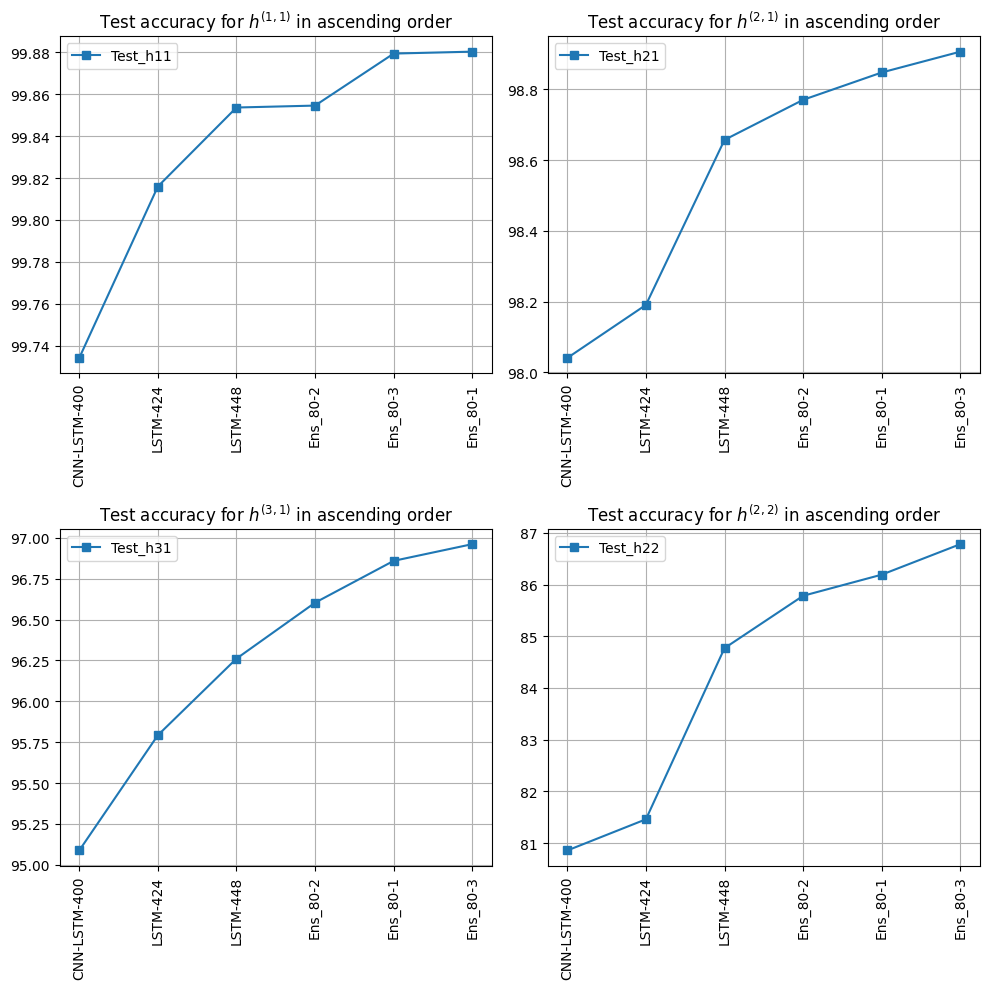

In [46]:
df80_t11 = df80['Test_h11'].sort_values(ascending = True)
df80_t21 = df80['Test_h21'].sort_values(ascending = True)
df80_t31 = df80['Test_h31'].sort_values(ascending = True)
df80_t22 = df80['Test_h22'].sort_values(ascending = True)

fig, ax = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
df80_t11.plot(ax = ax[0,0], style='s-')
ax[0,0].grid()
ax[0,0].set_title('Test accuracy for $h^{(1,1)}$ in ascending order')
ax[0,0].set_xticks(range(len(df80.index)))
ax[0,0].set_xticklabels(df80_t11.index)
ax[0,0].tick_params(axis='x', labelrotation=90)
ax[0,0].legend()

df80_t21.plot(ax = ax[0,1],style='s-')
ax[0,1].grid()
ax[0,1].set_title('Test accuracy for $h^{(2,1)}$ in ascending order')
ax[0,1].tick_params(axis='x', labelrotation=90)
ax[0,1].set_xticks(range(len(df80.index)))
ax[0,1].set_xticklabels(df80_t21.index)
ax[0,1].set_xticks(range(len(df80.index)))
ax[0,1].legend()

df80_t31.plot(ax = ax[1,0],style='s-')
ax[1,0].grid()
ax[1,0].set_title('Test accuracy for $h^{(3,1)}$ in ascending order')
ax[1,0].tick_params(axis='x', labelrotation=90)
ax[1,0].set_xticks(range(len(df80.index)))
ax[1,0].set_xticklabels(df80_t31.index)
ax[1,0].set_xticks(range(len(df80.index)))
ax[1,0].legend()

df80_t22.plot(ax = ax[1,1],style='s-')
ax[1,1].grid()
ax[1,1].set_title('Test accuracy for $h^{(2,2)}$ in ascending order')
ax[1,1].tick_params(axis='x', labelrotation=90)
ax[1,1].set_xticks(range(len(df80.index)))
ax[1,1].set_xticklabels(df80_t22.index)
ax[1,1].set_xticks(range(len(df80.index)))
ax[1,1].legend()
plt.savefig('Test80_accuracies_all')

# Accuracies (72% dataset)

In [47]:
test_acc_all = np.array([acctsG384,acctsG416, acctsR256, acctsR400, acctsL256, acctsL384, acctsL400, 
                         acctsl400, acctsl424, acctsl448, acctsl456,
                        accts_ens_1, accts_ens_2,accts_ens_3,accts_ens_4])

train_acc_all = np.array([acctG384,acctG416, acctR256, acctR400, acctL256, acctL384, acctL400,
                         acctl400, acctl424, acctl448, acctl456,
                         acct_ens_1,acct_ens_2,acct_ens_3,acct_ens_4])

In [48]:
mds = ['CNN-GRU-384','CNN-GRU-416', 'ResNet-GRU-256', 'ResNet-GRU-400',
    'CNN-LSTM-256', 'CNN-LSTM-384', 
       'CNN-LSTM-400',
     'LSTM-400','LSTM-424','LSTM-448','LSTM-456',
       'Ens-1', 'Ens-2', 'Ens-3', 'Ens-4' ]
acc_dict = {'Train_h11': train_acc_all[:,0],'Train_h21': train_acc_all[:,1],
            'Train_h31': train_acc_all[:,2], 'Train_h22': train_acc_all[:,3],
            'Test_h11':test_acc_all[:,0], 'Test_h21':test_acc_all[:,1],'Test_h31':test_acc_all[:,2],
           'Test_h22':test_acc_all[:,3]}
df = pd.DataFrame(acc_dict, index = mds)
df.to_csv('train_test_all.csv')
df

,Train_h11,Train_h21,Train_h31,Train_h22,Test_h11,Test_h21,Test_h31,Test_h22
CNN-GRU-384,98.984959,88.973642,89.202137,53.393233,98.237246,84.835787,69.292856,31.733991
CNN-GRU-416,99.005202,92.240972,92.831073,63.724444,98.254360,88.637330,77.689815,45.370631
ResNet-GRU-256,98.402066,86.792968,82.049005,48.081406,97.873985,84.052402,69.541286,37.142053
ResNet-GRU-400,99.759083,95.995504,97.743110,79.079026,99.223240,92.454882,86.619520,59.443405
CNN-LSTM-256,99.743288,97.389939,98.600504,83.219239,99.306050,94.373872,88.606966,62.327410
CNN-LSTM-384,99.879772,98.869331,99.608031,94.216460,99.130492,94.766944,87.852841,62.321337
CNN-LSTM-400,99.988345,99.878085,99.942646,99.499610,99.740528,98.068313,95.188725,81.007193
LSTM-400,99.908142,98.334898,99.209467,88.901259,99.378371,94.137034,88.010180,65.046346
LSTM-424,99.984818,99.739607,99.923324,99.194439,99.563314,97.066309,93.192445,74.466840
LSTM-448,99.980218,99.789754,99.889279,99.219589,99.735007,97.514036,94.235855,78.626123


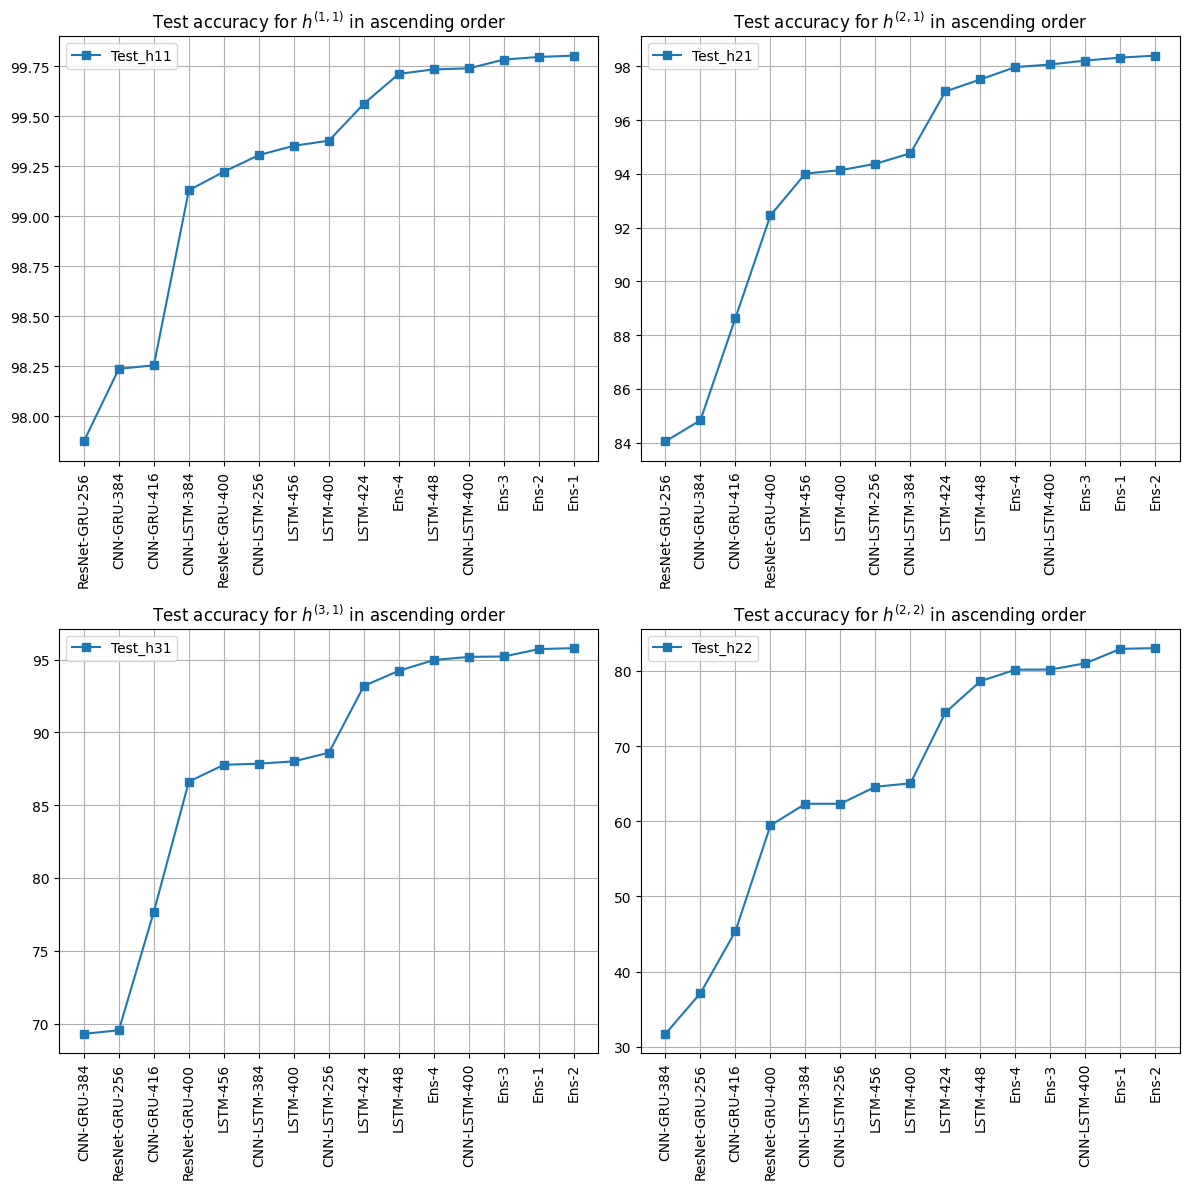

In [49]:
df_t11 = df['Test_h11'].sort_values(ascending = True)
df_t21 = df['Test_h21'].sort_values(ascending = True)
df_t31 = df['Test_h31'].sort_values(ascending = True)
df_t22 = df['Test_h22'].sort_values(ascending = True)

fig, ax = plt.subplots(2,2, figsize = (12,12), tight_layout = True)
df_t11.plot(ax = ax[0,0], style='s-')
ax[0,0].grid()
ax[0,0].set_title('Test accuracy for $h^{(1,1)}$ in ascending order')
ax[0,0].set_xticks(range(len(df.index)))
ax[0,0].set_xticklabels(df_t11.index)
ax[0,0].tick_params(axis='x', labelrotation=90)
ax[0,0].legend()

df_t21.plot(ax = ax[0,1],style='s-')
ax[0,1].grid()
ax[0,1].set_title('Test accuracy for $h^{(2,1)}$ in ascending order')
ax[0,1].tick_params(axis='x', labelrotation=90)
ax[0,1].set_xticks(range(len(df.index)))
ax[0,1].set_xticklabels(df_t21.index)
ax[0,1].set_xticks(range(len(df.index)))
ax[0,1].legend()

df_t31.plot(ax = ax[1,0],style='s-')
ax[1,0].grid()
ax[1,0].set_title('Test accuracy for $h^{(3,1)}$ in ascending order')
ax[1,0].tick_params(axis='x', labelrotation=90)
ax[1,0].set_xticks(range(len(df.index)))
ax[1,0].set_xticklabels(df_t31.index)
ax[1,0].set_xticks(range(len(df.index)))
ax[1,0].legend()

df_t22.plot(ax = ax[1,1],style='s-')
ax[1,1].grid()
ax[1,1].set_title('Test accuracy for $h^{(2,2)}$ in ascending order')
ax[1,1].tick_params(axis='x', labelrotation=90)
ax[1,1].set_xticks(range(len(df.index)))
ax[1,1].set_xticklabels(df_t22.index)
ax[1,1].set_xticks(range(len(df.index)))
ax[1,1].legend()
plt.savefig('Train_test_accuracies_all')

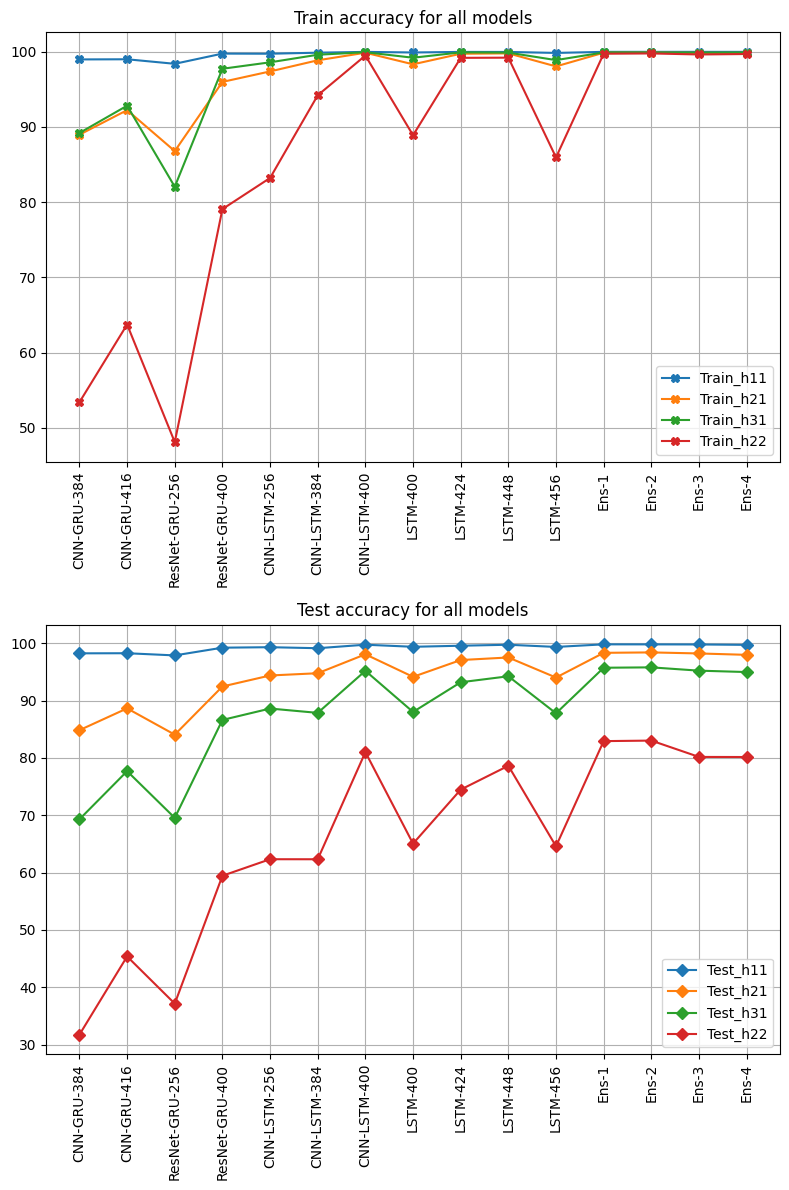

In [50]:
fig, ax = plt.subplots(2,1, figsize = (8,12), tight_layout = True)
df['Train_h11'].plot(ax = ax[0], style='X-')
df['Train_h21'].plot(ax = ax[0],style='X-')
df['Train_h31'].plot(ax = ax[0],style='X-')
df['Train_h22'].plot(ax = ax[0],style='X-')
ax[0].grid()
ax[0].set_title('Train accuracy for all models')
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_xticks(range(len(df.index)))
ax[0].set_xticklabels(df.index)
ax[0].legend(loc = 'lower right')


df['Test_h11'].plot(ax = ax[1], style='D-')
df['Test_h21'].plot(ax = ax[1],style='D-')
df['Test_h31'].plot(ax = ax[1],style='D-')
df['Test_h22'].plot(ax = ax[1],style='D-')
ax[1].grid()
ax[1].set_title('Test accuracy for all models')
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_xticks(range(len(df.index)))
ax[1].set_xticklabels(df.index)
ax[1].set_xticks(range(len(df.index)))
ax[1].legend()

plt.savefig('Train_test_4x_accuracies_all')

# MSE, MAE, R2 scores (72% dataset)

In [51]:
#Gather all the predictions together into an array
pred_list = np.array([yt_cnn_gru_384, yt_cnn_gru_416, yt_rsnet_gru_256, 
                      yt_rsnet_gru_400, yt_cnn_lstm_256, yt_cnn_lstm_384,
                      yt_cnn_lstm_400,  yt_lstm_400, yt_lstm_424,
                      yt_lstm_448, yt_lsm_456,
                      yts_ens_1, yts_ens_2, yts_ens_3, yts_ens_4])

pred_list.shape

(15, 181137, 4)

In [52]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2
#Perfect score values (benchmark of the target with itself)
#MSE, MAE -> 0,  R2 -> 1: perfect agreement
mse_bm = mse(y_test, y_test)
mae_bm = mae(y_test, y_test)
r2_bm = r2(y_test, y_test)
mse_bm, mae_bm, r2_bm

(0.0, 0.0, 1.0)

In [53]:
mse_list = []
mse_h11 = []
mse_h21 = []
mse_h31 = []
mse_h22 = []

mae_list = []
mae_h11 = []
mae_h21 = []
mae_h31 = []
mae_h22 = []

r2_list = []
r2_h11 = []
r2_h21 = []
r2_h31 = []
r2_h22 = []

for i in range(len(pred_list)):
    mse_i = mse(y_test, pred_list[i])
    mse_list.append(mse_i)
    mse_h11_i = mse(y_test[:,0], pred_list[i][:,0])
    mse_h21_i = mse(y_test[:,1], pred_list[i][:,1])
    mse_h31_i = mse(y_test[:,2], pred_list[i][:,2])
    mse_h22_i = mse(y_test[:,3], pred_list[i][:,3])
    mse_h11.append(mse_h11_i)
    mse_h21.append(mse_h21_i)
    mse_h31.append(mse_h31_i)
    mse_h22.append(mse_h22_i)
    
    mae_i = mae(y_test, pred_list[i])
    mae_list.append(mae_i)
    mae_h11_i = mae(y_test[:,0], pred_list[i][:,0])
    mae_h21_i = mae(y_test[:,1], pred_list[i][:,1])
    mae_h31_i = mae(y_test[:,2], pred_list[i][:,2])
    mae_h22_i = mae(y_test[:,3], pred_list[i][:,3])
    mae_h11.append(mae_h11_i)
    mae_h21.append(mae_h21_i)
    mae_h31.append(mae_h31_i)
    mae_h22.append(mae_h22_i)
    
    r2_i = r2(y_test, pred_list[i])
    r2_list.append(r2_i)
    r2_h11_i = r2(y_test[:,0], pred_list[i][:,0])
    r2_h21_i = r2(y_test[:,1], pred_list[i][:,1])
    r2_h31_i = r2(y_test[:,2], pred_list[i][:,2])
    r2_h22_i = r2(y_test[:,3], pred_list[i][:,3])
    r2_h11.append(r2_h11_i)
    r2_h21.append(r2_h21_i)
    r2_h31.append(r2_h31_i)
    r2_h22.append(r2_h22_i)
    

In [54]:
pred_dict = {'MSE_all': mse_list,
             'MSE_h11': mse_h11, 'MSE_h21': mse_h21 , 'MSE_h31': mse_h31, 'MSE_h22': mse_h22,
             'MAE_all': mae_list,
             'MAE_h11': mae_h11, 'MAE_h21': mae_h21 , 'MAE_h31': mae_h31, 'MAE_h22': mae_h22,
             'R2_all': r2_list,
             'r2_h11': r2_h11, 'r2_h21': r2_h21 , 'r2_h31': r2_h31, 'r2_h22': r2_h22,
            }
df_pred = pd.DataFrame(pred_dict, index = mds)
df_pred.to_csv('pred_mse_mae_all.csv')
df_pred

,MSE_all,MSE_h11,MSE_h21,MSE_h31,MSE_h22,MAE_all,MAE_h11,MAE_h21,MAE_h31,MAE_h22,R2_all,r2_h11,r2_h21,r2_h31,r2_h22
CNN-GRU-384,3.063604,0.026345,0.288621,0.717943,11.221506,0.584066,0.020173,0.183728,0.387055,1.745309,0.976415,0.995510,0.918559,0.996170,0.995423
CNN-GRU-416,2.516005,0.022359,0.213170,0.592623,9.235866,0.446427,0.018814,0.136455,0.294771,1.335669,0.982277,0.996189,0.939849,0.996838,0.996233
ResNet-GRU-256,3.441552,0.032859,0.327509,0.815907,12.589934,0.585590,0.024578,0.199893,0.400178,1.717711,0.973124,0.994399,0.907586,0.995647,0.994864
ResNet-GRU-400,1.797119,0.016093,0.124828,0.429316,6.618239,0.291314,0.010042,0.087939,0.181614,0.885661,0.989261,0.997257,0.964777,0.997710,0.997300
CNN-LSTM-256,1.564763,0.012664,0.094177,0.371702,5.780509,0.250990,0.008590,0.065061,0.153127,0.777180,0.991732,0.997841,0.973426,0.998017,0.997642
CNN-LSTM-384,1.793952,0.012129,0.089523,0.422266,6.651888,0.263005,0.009667,0.060937,0.164395,0.817023,0.991926,0.997933,0.974739,0.997747,0.997287
CNN-LSTM-400,0.981793,0.004417,0.034841,0.225327,3.662587,0.117395,0.003081,0.023192,0.068031,0.375274,0.996680,0.999247,0.990169,0.998798,0.998506
LSTM-400,1.523907,0.012284,0.099190,0.363841,5.620315,0.255210,0.007955,0.068782,0.162137,0.781966,0.991421,0.997906,0.972011,0.998059,0.997707
LSTM-424,1.025199,0.007354,0.049256,0.245902,3.798285,0.156235,0.005234,0.034129,0.091378,0.494201,0.995497,0.998747,0.986101,0.998688,0.998451
LSTM-448,0.920742,0.004924,0.048185,0.214291,3.415570,0.137493,0.003290,0.030286,0.080768,0.435626,0.995757,0.999161,0.986404,0.998857,0.998607


# MSE, MAE, R2 - 80% dataset

In [55]:
#Gather all the predictions together into an array
pred_list_80 = np.array([yt_cnn_lstm_400d72,
                         yt_lstm_424d,
                          yt_lstm_448d, 
                          yts_ens80_1, yts_ens80_2,  yts_ens80_3])

pred_list_80.shape

(6, 108682, 4)

In [56]:
mse_list = []
mse_h11 = []
mse_h21 = []
mse_h31 = []
mse_h22 = []

mae_list = []
mae_h11 = []
mae_h21 = []
mae_h31 = []
mae_h22 = []

r2_list = []
r2_h11 = []
r2_h21 = []
r2_h31 = []
r2_h22 = []

for i in range(len(pred_list_80)):
    mse_i = mse(y_test_80, pred_list_80[i])
    mse_list.append(mse_i)
    mse_h11_i = mse(y_test_80[:,0], pred_list_80[i][:,0])
    mse_h21_i = mse(y_test_80[:,1], pred_list_80[i][:,1])
    mse_h31_i = mse(y_test_80[:,2], pred_list_80[i][:,2])
    mse_h22_i = mse(y_test_80[:,3], pred_list_80[i][:,3])
    mse_h11.append(mse_h11_i)
    mse_h21.append(mse_h21_i)
    mse_h31.append(mse_h31_i)
    mse_h22.append(mse_h22_i)
    
    mae_i = mae(y_test_80, pred_list_80[i])
    mae_list.append(mae_i)
    mae_h11_i = mae(y_test_80[:,0], pred_list_80[i][:,0])
    mae_h21_i = mae(y_test_80[:,1], pred_list_80[i][:,1])
    mae_h31_i = mae(y_test_80[:,2], pred_list_80[i][:,2])
    mae_h22_i = mae(y_test_80[:,3], pred_list_80[i][:,3])
    mae_h11.append(mae_h11_i)
    mae_h21.append(mae_h21_i)
    mae_h31.append(mae_h31_i)
    mae_h22.append(mae_h22_i)
    
    r2_i = r2(y_test_80, pred_list_80[i])
    r2_list.append(r2_i)
    r2_h11_i = r2(y_test_80[:,0], pred_list_80[i][:,0])
    r2_h21_i = r2(y_test_80[:,1], pred_list_80[i][:,1])
    r2_h31_i = r2(y_test_80[:,2], pred_list_80[i][:,2])
    r2_h22_i = r2(y_test_80[:,3], pred_list_80[i][:,3])
    r2_h11.append(r2_h11_i)
    r2_h21.append(r2_h21_i)
    r2_h31.append(r2_h31_i)
    r2_h22.append(r2_h22_i)

In [57]:
pred_dict_80 = {'MSE_all': mse_list,
             'MSE_h11': mse_h11, 'MSE_h21': mse_h21 , 'MSE_h31': mse_h31, 'MSE_h22': mse_h22,
             'MAE_all': mae_list,
             'MAE_h11': mae_h11, 'MAE_h21': mae_h21 , 'MAE_h31': mae_h31, 'MAE_h22': mae_h22,
             'R2_all': r2_list,
             'r2_h11': r2_h11, 'r2_h21': r2_h21 , 'r2_h31': r2_h31, 'r2_h22': r2_h22,
            }
df_pred_80 = pd.DataFrame(pred_dict_80, index = mds2)
df_pred_80.to_csv('pred_mse_mae_80_all.csv')
df_pred_80

,MSE_all,MSE_h11,MSE_h21,MSE_h31,MSE_h22,MAE_all,MAE_h11,MAE_h21,MAE_h31,MAE_h22,R2_all,r2_h11,r2_h21,r2_h31,r2_h22
CNN-LSTM-400,1.035332,0.004785,0.036253,0.237611,3.862682,0.120158,0.003202,0.023665,0.070205,0.383559,0.996501,0.999183,0.989677,0.998727,0.998416
LSTM-424,0.758428,0.002466,0.033851,0.177840,2.819556,0.107874,0.002043,0.021908,0.058814,0.348733,0.996958,0.999579,0.990361,0.999047,0.998844
LSTM-448,0.676418,0.002650,0.029582,0.156512,2.516930,0.093958,0.001803,0.016921,0.053477,0.303629,0.997313,0.999547,0.991577,0.999162,0.998968
Ens_80-1,0.529085,0.001518,0.020767,0.122265,1.971789,0.080754,0.001297,0.013848,0.043540,0.264331,0.998091,0.999741,0.994087,0.999345,0.999192
Ens_80-2,0.580193,0.001951,0.022442,0.131475,2.164903,0.085290,0.001583,0.014657,0.046917,0.278004,0.997921,0.999667,0.993610,0.999296,0.999112
Ens_80-3,0.499478,0.001481,0.018458,0.113487,1.864485,0.077025,0.001279,0.012845,0.041424,0.252553,0.998280,0.999747,0.994744,0.999392,0.999236
